<center><h2>Inter-IIT Tech Meet 2018</h2> 
<h3> Optimal Bidding (Part II) </h3><br></center>
<b>Author</b> : Alan Aipe <br>
<b>Last Updated Date</b> : 15-12-2017 <br>
<b>Description</b> : Cost optimization algorithm with a given price, community demand and solar plant output datapoints

In [47]:
# External Libraries
import scipy.io 
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps

In [48]:
# Loading dataset. As algorithm, to make predictions closer to real values, is still under construction, optimization of cost 
# is done on oracle predictions. 
dataset = scipy.io.loadmat('OptimalBiddingTrain.mat')
# Global variables
# Inorder to get a subset of the total 900 day dataset, n1 ans n2 are used.
n1 = 1 # Start day. For example is n1 is 32, that means we take datapoints from 32nd day(inclusive) onwards.
n2 = 31 #n1+30+n1%2 # End day. For example is n1 is 59, that means we take datapoints until 59th day(inclusive).
offset = 0
n_days = n2-n1+1 # Number of days in the subset
n_blocks = 24 # Number of bidding blocks in a given day
battery_usage_limit = 5.0 # Amount of KWh that can be transferred between battery and community in  a block
battery_discharging_efficency = 0.8 # Battery discharging efficiency
battery_max_capacity = 25
discom_unit_price = 7 # Per unit price of electrcity given by discom
price_pred = (dataset['Price_Train_pred'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)] # Oracle market price prediction
demand_pred = (dataset['Demand_Train_pred'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)] # Oracle community demand prediction
solar_pred = (dataset['Solar_Train_pred'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)] # Oracle solar plant output prediction
price_real = (dataset['Price_Train'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)] # Actual market price
demand_real = (dataset['Demand_Train'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)] # Actual community demand
solar_real = (dataset['Solar_Train'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)] # Actual solar power plant output

Cost optimization algorithm involves following steps:
1. Find community demand which cannot be satisfied by solar power plant. For this, solar plant output is subtracted from
   overall demand. In the code, this demand is saved in 'non_solar_demand' variable.
2. In non_solar_demand, there is possibillity of negetive values as well, signifying solar energy excess compared to overall demand. Check for this excess and redistribute them into other blocks using battery (taking into consideration charging and discharging limits as well as efficiency) so that free energy is not wasted.
3. After distributing excess solar energy to satisfy demand, resulting demand should again be redistributed such that demand from high price blocks should be transferred to low price blocks.

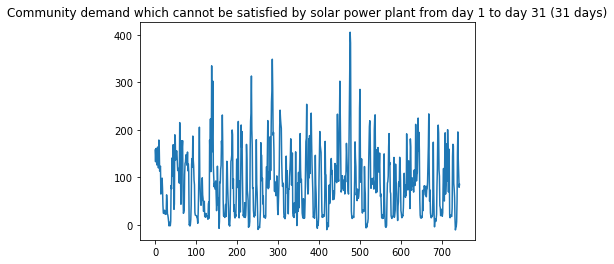

Total demand for 31 days =  64604.46 KWh
Total excess solar energy for 31 days after satisfying demand in the block =  135.79 KWh
Total cost of electricity consumption if demand is satisfied by electricity market and DISCOM at this stage = Rs. 200647.79


In [49]:
# Step 1 - Identifying community demand which cannot be satisfied by solar power plant

non_solar_demand = (demand_pred - solar_pred)
plt.plot(range(int(n_blocks*n_days)),non_solar_demand)
plt.title("Community demand which cannot be satisfied by solar power plant from day "+str(n1)+" to day "+str(n2)+" ("+str(n_days)+" days)")
plt.show()
positive_demand = 0
total_excess_energy = 0
total_money_spent = 0
for j in range(len(non_solar_demand)):
    i = non_solar_demand[j]
    if i>0:
        positive_demand+=i
        if price_pred[j]<discom_unit_price: # If predicted price is lesser than discom unit price, then buy from market with real price
            total_money_spent += price_real[j]*i
        else:
            total_money_spent += discom_unit_price*i
        
    elif i<0:
        total_excess_energy-=i
total_money_spent = np.round(total_money_spent,2)
print("Total demand for",n_days,"days = ",positive_demand,"KWh")
print("Total excess solar energy for",n_days,"days after satisfying demand in the block = ",total_excess_energy,"KWh")
print("Total cost of electricity consumption if demand is satisfied by electricity market and DISCOM at this stage = Rs.",total_money_spent)
curr_expenditure = total_money_spent
initial_expenditure = total_money_spent

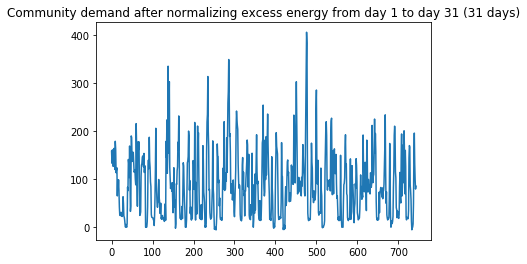

Total demand for 31 days =  64526.124 KWh
Total excess solar energy for 31 days after satisfying demand in the block =  37.87 KWh
Total cost of electricity consumption if demand is satisfied by electricity market and DISCOM at this stage = Rs. 200272.01
Money saved with respect to previous stage = Rs. 375.78
Total Money saved by algorithm = Rs. 375.78


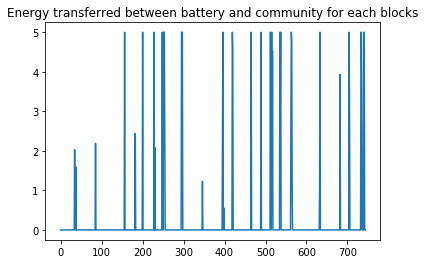

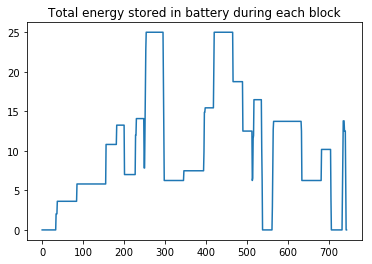

Efficiency of algorithm w.r.t battery usage until this stage =  41.23 %


In [50]:
# Step 2 - Redistributing excess free solar energy using battery
battery_usage = np.zeros(int(n_days*n_blocks)) # Battery usage during each block.
usable_excess = 0.0 # Stores the total usable excess transferred to battery until that point of time. Battery discharging 
# efficiency is 80%
price_pred[price_pred>discom_unit_price] = discom_unit_price #If preedicted price is greater than discom price, its better to buy from discom
price_desc_sort_index = np.argsort(-price_pred) # list of indexes of descending order of price predictions
# Checking whether there is any excess
temp = non_solar_demand < 0
battery_charge = np.zeros(int(n_days*n_blocks))
if True in temp:
    for i in range(len(non_solar_demand)):
        if non_solar_demand[i] < 0:
            # Excess energy detected
            available_excess = abs(non_solar_demand[i])
            energy_transferred_to_battery = 0.0
            if available_excess > (battery_usage_limit - battery_usage[i]): # Battery charging limit
                energy_transferred_to_battery = (battery_usage_limit - battery_usage[i])
            else:
                energy_transferred_to_battery = available_excess
            # If battery is charged with x KWh it can only discharge 0.8*x KWh (80% efficiency)
            usable_excess += battery_discharging_efficency*energy_transferred_to_battery
            battery_usage[i] += energy_transferred_to_battery
            non_solar_demand[i] += energy_transferred_to_battery # Update the -ve non-solar demand
            # Usable excess obtained from this block should be distributed to future blocks having higher price prediction 
            # and positive demand
            if usable_excess > 0:
                for j in price_desc_sort_index:
                    if non_solar_demand[j] > 0 and battery_usage[j]<battery_usage_limit and j>i:
                        required_energy_transfer = min(non_solar_demand[j],usable_excess)
                        if required_energy_transfer > (battery_usage_limit - battery_usage[j]):
                            energy_transferred_from_battery = (battery_usage_limit - battery_usage[j])
                        else:
                            energy_transferred_from_battery = required_energy_transfer
                        energy_transferred_from_battery/=battery_discharging_efficency
                        bandwidth = float('inf')
                        for k in range(i,j+1):
                            temp = energy_transferred_from_battery
                            if battery_charge[k]+ energy_transferred_from_battery > battery_max_capacity:
                                temp = battery_max_capacity - battery_charge[k]
                            if temp<bandwidth:
                                bandwidth = temp
                        for k in range(i,j+1):
                            battery_charge[k] += bandwidth
                        energy_transferred_from_battery = bandwidth*battery_discharging_efficency
                        usable_excess -= energy_transferred_from_battery
                        battery_usage[j] += energy_transferred_from_battery
                        non_solar_demand[j] -= energy_transferred_from_battery
                    if usable_excess <= 0: # Excess energy has been distributed
                        break
                if usable_excess > 0: # Some excess energy could not be accomodated in any of future blocks
                    excess_units_transferred = usable_excess/battery_discharging_efficency 
                    non_solar_demand[i] -= excess_units_transferred
                    battery_usage[i] -= excess_units_transferred
                    usable_excess = 0 # Keep it stored in battery itself 
plt.plot(range(int(n_blocks*n_days)),non_solar_demand)
plt.title("Community demand after normalizing excess energy from day "+str(n1)+" to day "+str(n2)+" ("+str(n_days)+" days)")
plt.show()
positive_demand = 0
total_excess_energy = 0
total_money_spent = 0
for j in range(len(non_solar_demand)):
    i = non_solar_demand[j]
    if i>0:
        positive_demand+=i
        if price_pred[j]<discom_unit_price: # If predicted price is lesser than discom unit price, then buy from market with real price
            total_money_spent += price_real[j]*i
        else:
            total_money_spent += discom_unit_price*i
        
    elif i<0:
        total_excess_energy-=i
total_money_spent = np.round(total_money_spent,2)
print("Total demand for",n_days,"days = ",positive_demand,"KWh")
print("Total excess solar energy for",n_days,"days after satisfying demand in the block = ",total_excess_energy,"KWh")
print("Total cost of electricity consumption if demand is satisfied by electricity market and DISCOM at this stage = Rs.",total_money_spent)
print("Money saved with respect to previous stage = Rs.", curr_expenditure-total_money_spent)
print("Total Money saved by algorithm = Rs.", initial_expenditure-total_money_spent)
curr_expenditure = total_money_spent
plt.plot(range(int(n_blocks*n_days)),battery_usage)
plt.title("Energy transferred between battery and community for each blocks")
plt.show()
plt.plot(range(int(n_days*n_blocks)),battery_charge)
plt.title("Total energy stored in battery during each block")
plt.show()
print("Efficiency of algorithm w.r.t battery usage until this stage = ",np.round(100*simps(battery_charge,dx=1)/(battery_max_capacity*int(n_days*n_blocks)),2),"%")

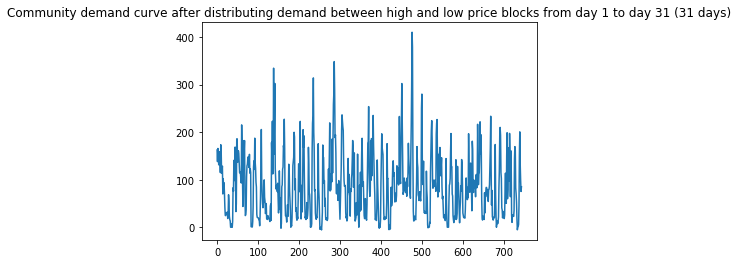

Daily bill of day 1 = Rs. 7584.2442
Daily bill of day 2 = Rs. 3222.242
Daily bill of day 3 = Rs. 9603.0152
Daily bill of day 4 = Rs. 8492.49602
Daily bill of day 5 = Rs. 4546.9728
Daily bill of day 6 = Rs. 8246.3658
Daily bill of day 7 = Rs. 8069.69126
Daily bill of day 8 = Rs. 7119.81408
Daily bill of day 9 = Rs. 8146.1567
Daily bill of day 10 = Rs. 7384.01326
Daily bill of day 11 = Rs. 5151.31532
Daily bill of day 12 = Rs. 10621.5875
Daily bill of day 13 = Rs. 9473.2684
Daily bill of day 14 = Rs. 5787.456
Daily bill of day 15 = Rs. 4321.0016
Daily bill of day 16 = Rs. 6405.6734
Daily bill of day 17 = Rs. 4212.7189
Daily bill of day 18 = Rs. 4051.8059
Daily bill of day 19 = Rs. 7708.687
Daily bill of day 20 = Rs. 11504.8005
Daily bill of day 21 = Rs. 7789.9263
Daily bill of day 22 = Rs. 5183.22772
Daily bill of day 23 = Rs. 8858.886
Daily bill of day 24 = Rs. 3794.40986
Daily bill of day 25 = Rs. 3504.2961
Daily bill of day 26 = Rs. 3475.2746
Daily bill of day 27 = Rs. 6618.2348
Daily

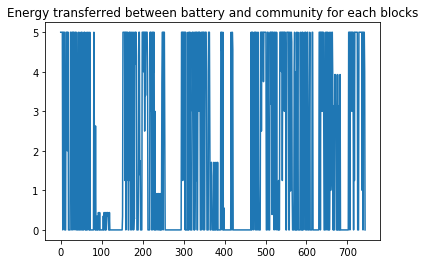

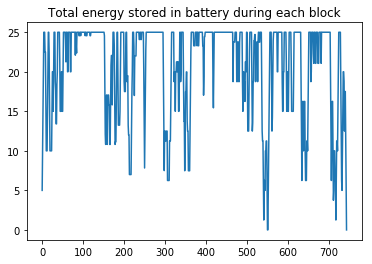

Efficiency of algorithm w.r.t battery usage until this stage =  83.24 %
Out of 7 days of buying electricity from DISCOM, battery was used to full extent on 7 days.


In [51]:
# Step 3 - Redistributing demand between low and high price blocks
price_asc_sort_index = np.argsort(1.2*price_pred) # list of indexes of ascending order of price predictions
required_units = 0.0
negetive_demand_points = np.where(non_solar_demand<0)
for i in price_desc_sort_index:
    if non_solar_demand[i] > 0:
            # Demand at high price block
            available_demand = non_solar_demand[i]
            energy_transferred_from_battery = 0.0
            if available_demand > (battery_usage_limit - battery_usage[i]): # Battery charging limit
                energy_transferred_from_battery = (battery_usage_limit - battery_usage[i])
            else:
                energy_transferred_from_battery = available_demand
            # If battery is discharged with x KWh it should be chargeed to x/0.8 KWh (80% efficiency)
            required_units += energy_transferred_from_battery/battery_discharging_efficency
            battery_usage[i] += energy_transferred_from_battery
            non_solar_demand[i] -= energy_transferred_from_battery # Update the -ve non-solar demand
            # Demand from this block is distributed to lower priced former blocks
            if required_units > 0:
                for j in price_asc_sort_index:
                    if price_pred[j] < price_pred[i] and battery_usage[j]<battery_usage_limit and j<i:
                        if required_units > (battery_usage_limit - battery_usage[j]):
                            energy_transferred_to_battery = (battery_usage_limit - battery_usage[j])
                        else:
                            energy_transferred_to_battery = required_units
                        bandwidth = float('inf')
                        for k in range(j,i+1):
                            temp = energy_transferred_to_battery
                            if battery_charge[k]+ energy_transferred_to_battery > battery_max_capacity:
                                temp = battery_max_capacity - battery_charge[k]
                                if temp<0:
                                    temp = 0
                            if temp<bandwidth:
                                bandwidth = temp
                        if bandwidth <=0:
                            continue
                        energy_transferred_to_battery = bandwidth
                        for k in range(j,i+1):
                            battery_charge[k] += energy_transferred_to_battery
                        required_units -= energy_transferred_to_battery
                        battery_usage[j] += energy_transferred_to_battery
                        non_solar_demand[j] += energy_transferred_to_battery
                    if required_units <= 0: # Excess energy has been distributed
                        break
                if required_units > 0: # If some excess units cannot be served by former blocks, it is transferred back to high price block
                    excess_units_transferred = required_units*battery_discharging_efficency 
                    non_solar_demand[i] += excess_units_transferred
                    battery_usage[i] -= excess_units_transferred
            required_units = 0.0
            if price_pred[i] >= discom_unit_price: # To ensure battery is used fully during blocks when electricity is bought from DISCOM
                remaining_battery_transfer_rate = min(battery_charge[i],battery_usage_limit - battery_usage[i])
                battery_usage[i] = battery_usage_limit
                battery_charge[i] -= remaining_battery_transfer_rate
                non_solar_demand[i] -= remaining_battery_transfer_rate
                if remaining_battery_transfer_rate>0:
                    j=i+1
                    while j<n_days*n_blocks:
                        charge = min(battery_max_capacity-battery_charge[j],battery_usage_limit - battery_usage[j],remaining_battery_transfer_rate/battery_discharging_efficency)
                        battery_usage [j]+=charge
                        battery_charge[j] += charge
                        non_solar_demand[j] += charge
                        remaining_battery_transfer_rate -= charge*battery_discharging_efficency
                        if remaining_battery_transfer_rate<=0:
                            break
                        j+=1
plt.plot(range(int(n_blocks*n_days)),non_solar_demand)
plt.title("Community demand curve after distributing demand between high and low price blocks from day "+str(n1)+" to day "+str(n2)+" ("+str(n_days)+" days)")
plt.show()
positive_demand = 0
total_excess_energy = 0
total_money_spent = 0
daily_bill = 0
bill_history = []
count_day = 1
count_strays = 0
count_discom_days = 0
for j in range(len(non_solar_demand)):
    i = non_solar_demand[j]
    if i>0:
        positive_demand+=i
        if price_pred[j]<discom_unit_price: # If predicted price is lesser than discom unit price, then buy from market with real price
            total_money_spent += price_real[j]*i
            daily_bill += price_real[j]*i
        else:
            count_discom_days += 1
            if battery_usage[j]<battery_usage_limit and battery_charge[j]!=0:
                count_strays += 1
            total_money_spent += discom_unit_price*i
            daily_bill += discom_unit_price*i
        
    elif i<0:
        total_excess_energy-=i
    if j!=0 and j%n_blocks==n_blocks-1:
        print("Daily bill of day",count_day,"= Rs.",daily_bill)
        bill_history.append(daily_bill)
        daily_bill=0
        count_day+=1
total_money_spent = np.round(total_money_spent,2)
print("Total demand for",n_days,"days = ",positive_demand,"KWh")
print("Total excess solar energy for",n_days,"days after satisfying demand in the block = ",total_excess_energy,"KWh")
print("Total cost of electricity consumption if demand is satisfied by electricity market and DISCOM at this stage = Rs.",total_money_spent)
print("Money saved with respect to previous stage = Rs.", curr_expenditure-total_money_spent)
print("Total Money saved by algorithm = Rs.", initial_expenditure-total_money_spent)
curr_expenditure = total_money_spent
plt.plot(range(int(n_blocks*n_days)),battery_usage)
plt.title("Energy transferred between battery and community for each blocks")
plt.show()
plt.plot(range(int(n_days*n_blocks)),battery_charge)
plt.title("Total energy stored in battery during each block")
plt.show()
print("Efficiency of algorithm w.r.t battery usage until this stage = ",np.round(100*simps(battery_charge,dx=1)/(battery_max_capacity*int(n_days*n_blocks)),2),"%")
print("Out of",count_discom_days,"days of buying electricity from DISCOM, battery was used to full extent on",count_discom_days-count_strays,"days.")

Output of this problem should be the bid price and bid quantity. Basic assumption which has been used in this code is that bid price is same as predicted price. Bid quantity is given by latest community demand (non_solar_demand variable). 